<a href="https://colab.research.google.com/github/Seif-Tarek/IMDB_InsightsAndPrediction/blob/master/IMDB_Movies_Revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import ast
from collections import Counter
import os
import json
from pandas.io.json import json_normalize
import unicodedata
import re
from matplotlib import pyplot as plt


In [0]:
def addDateFeatures(data):
    """ Adds extra date features like: day, month, quarter and year """
    data['release_year'] = pd.to_datetime(data['release_date']).dt.year
    data['release_quarter'] = pd.to_datetime(data['release_date']).dt.quarter
    data['release_month'] = pd.to_datetime(data['release_date']).dt.month
    data['release_day'] = pd.to_datetime(data['release_date']).dt.day

    data['release_year'].loc[data['release_year'] > 2019] -= 100 # Fixing release years.

    # Filling the columns NaN values (only one NaN value exist in test data) with mode of the data
    data['release_year'].fillna(data['release_year'].mode()[0],inplace = True)
    data['release_quarter'].fillna(data['release_quarter'].mode()[0],inplace = True)
    data['release_month'].fillna(data['release_month'].mode()[0],inplace = True)
    data['release_day'].fillna(data['release_day'].mode()[0],inplace = True)

    data['release_year'] = data['release_year'].astype(int)
    data['release_quarter'] = data['release_quarter'].astype(int)
    data['release_month'] = data['release_month'].astype(int)
    data['release_day']= data['release_day'].astype(int)

    # Reshape the release date column to from this format: 'month-day-year' to this format: 'year-month-day'
    data['release_date'] = data['release_month'].astype(str) + '/' + data['release_day'].astype(str) + '/' + data['release_year'].astype(str)
    data['release_date'] = pd.to_datetime(data['release_date'], format="%m/%d/%Y")
    data['release_day_of_week'] = data['release_date'].dt.dayofweek # The day of the week with Monday = 0, Sunday = 6
    return data

def addExtraFeatures(data):
    """ Adds extra features """
    pass

def stringToJSON(data):
    """ change strings to JSON format for a pandas coloumn """
    data.fillna(value = '[{}]',inplace = True) # JSON empty string format
    data.loc[data == '[]'] = '[{}]'
    return data.apply(lambda entry: re.compile(r'\\x([0-9a-fA-F]{2})').sub('',entry.replace("None",'"ddd"'))).apply(ast.literal_eval)

def addGenreFeatures(data,data2):
    """ Adds extra features """
    #data['genre'] = stringToJSON(data['genres'])
    #train_genres = pd.DataFrame(
    #{
    #    'id' : data['id'].values.repeat(data['genres'].str.len(), axis = 0),
    #    'genre' : np.concatenate(data['genres'].tolist())
    #})

    #train_genres['genre'] = train_genres['genre'].map(lambda genre: genre.get('name'))
    #train_genres = train_genres.set_index('id').genre.str.get_dummies().sum(level = 0)
    #data = pd.merge(data, train_genres, on = 'id', how = 'outer')

    '''Adds the num_genres and ont hot encoding of genres'''
    list_of_genres = list(data['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

    genres_unique = set(x for l in list_of_genres for x in l)
    data['num_genres'] = data['genres'].apply(lambda x: len(x) if x != {} else 0)
    data['all_genres'] = data['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    
    for genre in genres_unique:
        data[genre] = data['all_genres'].apply(lambda x: 1 if genre in x else 0)
      
    
    data2['num_genres'] = data2['genres'].apply(lambda x: len(x) if x != {} else 0)
    data2['all_genres'] = data2['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    
    for genre in genres_unique:
        data2[genre] = data2['all_genres'].apply(lambda x: 1 if genre in x else 0)
    
    #train = train.drop(['genres', 'all_genres'], axis=1)
    return data,data2

def is_en(df,df2):
    df['is_english'] = 0
    df.loc[df['original_language']=="en", 'is_english'] = 1
    df2['is_english'] = 0
    df2.loc[df2['original_language']=="en", 'is_english'] = 1
    return df,df2

def cast_preproccessing(train):
    cast_list = []
    male = 0
    female = 0
    Hero_male = 0
    Hero_female = 0

    for x in train['cast']:
        try:
            for item in ast.literal_eval(x):
                cast_list.append(item['name'])
                if item['order'] == 0:
                    if item['gender'] == 1:
                        Hero_female += 1
                    elif item['gender'] == 2:
                        Hero_male += 1

                if item['gender'] == 1:
                    female += 1
                elif item['gender'] == 2:
                    male += 1
        except:
            continue
    return cast_list,male,female,Hero_male,Hero_female

def is_famous(df,df2):
    output = cast_preproccessing(df)
    c = Counter(output[0])
    list_freq = [i[0] for i in c.most_common(50)]
    for i in list_freq[:15]:
        df[i] = 0
    df['is Famous'] = 0
    df['numberOfCast'] = 0
    df['Male_cast'] = 0
    df['Female_cast'] = 0
    df['unknown_gender_cast'] = 0
    for idx, row in df.iterrows():
        try:
            df['numberOfCast'][idx] = len(ast.literal_eval(row['cast']))
            for item in ast.literal_eval(row['cast']):
                if item['name'] in list_freq:
                    df['is Famous'][idx]=1
                if item['name'] in list_freq[:15]:
                    df[item['name']][idx]=1
                if item['gender'] == 2:
                  df['Male_cast'][idx] +=1
                elif item['gender'] == 1:
                  df['Female_cast'][idx] +=1
                else:
                  df['unknown_gender_cast'][idx] += 1 
        except:
            continue
    
    df = text_to_dict(df, ['cast'])
    list_of_cast_characters = list(df['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
    top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
    for g in top_cast_characters:
        df['cast_character_' + g] = df['cast'].apply(lambda x: 1 if g in str(x) else 0)

    for i in list_freq[:15]:
        df2[i] = 0
    df2['is Famous'] = 0
    df2['numberOfCast'] = 0
    df2['Male_cast'] = 0
    df2['Female_cast'] = 0
    df2['unknown_gender_cast'] = 0
    for idx, row in df2.iterrows():
        try:
            df2['numberOfCast'][idx] = len(ast.literal_eval(row['cast']))
            for item in ast.literal_eval(row['cast']):
                if item['name'] in list_freq:
                    df2['is Famous'][idx]=1
                if item['name'] in list_freq[:15]:
                    df2[item['name']][idx]=1
                if item['gender'] == 2:
                  df2['Male_cast'][idx] +=1
                elif item['gender'] == 1:
                  df2['Female_cast'][idx] +=1
                else:
                  df2['unknown_gender_cast'][idx] += 1 
        except:
            continue
    
    df2 = text_to_dict(df2, ['cast'])
    for g in top_cast_characters:
        df2['cast_character_' + g] = df2['cast'].apply(lambda x: 1 if g in str(x) else 0)
    return df,df2

def add_production_companies_features(df,df2):
    list_of_companies = list(df['production_companies'].apply(lambda x: [i['name'].replace(' ', '') for i in x] if x != {} else []).values)
    top_companies = [list(m) for m in Counter([i for j in list_of_companies for i in j]).most_common(10)]
    top_companies = pd.DataFrame(data=top_companies, columns=['Production Company', 'Number of Productions'])
    top_production_companies = top_companies['Production Company']
    df['num_companies'] = df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
    df['all_companies'] = df['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for company in top_production_companies:
        df[ 'is_by_'+company] = df['all_companies'].apply(lambda x: 1 if company in x else 0)
      
    df2['num_companies'] = df2['production_companies'].apply(lambda x: len(x) if x != {} else 0)
    df2['all_companies'] = df2['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for company in top_production_companies:
        df2[ 'is_by_'+company] = df2['all_companies'].apply(lambda x: 1 if company in x else 0)
    
    return df,df2

def add_production_countries_features(df,df2):
    list_of_production_countries = list(df['production_countries'].apply(lambda x: [i['name'].replace(' ', '') for i in x] if x != {} else []).values)
    top_countries = [list(m) for m in Counter([i for j in list_of_production_countries for i in j]).most_common(10)]
    top_countries = pd.DataFrame(data=top_countries, columns=['Production Country', 'Number of Productions'])
    top_production_countries = top_countries['Production Country'] 
    df['num_countries'] = df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
    df['all_countries'] = df['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for company in top_production_countries:
        df[ 'is_by_'+company] = df['all_countries'].apply(lambda x: 1 if company in x else 0)
      
    df2['num_countries'] = df2['production_countries'].apply(lambda x: len(x) if x != {} else 0)
    df2['all_countries'] = df2['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for company in top_production_countries:
        df2[ 'is_by_'+company] = df2['all_countries'].apply(lambda x: 1 if company in x else 0)
    
    return df,df2

def add_keywords_features(df,df2):
  allKeywords = list(df['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
  df['num_of_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
  df['allKeywords'] = df['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
  top_keywords = [m[0] for m in Counter([i for j in allKeywords for i in j]).most_common(10)]
  for g in top_keywords:
      df['keyword_' + g] = df['allKeywords'].apply(lambda x: 1 if g in x else 0)

  df2['num_of_Keywords'] = df2['Keywords'].apply(lambda x: len(x) if x != {} else 0)
  df2['allKeywords'] = df2['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
  for g in top_keywords:
      df2['keyword_' + g] = df2['allKeywords'].apply(lambda x: 1 if g in x else 0)
  return df,df2

def add_crew_features(df,df2):
  df['numberOfCrew'] = df['crew'].apply(lambda x: len(x) if x != {} else 0)
  df['unknown_gender_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
  df['Female_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
  df['Male_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

  list_of_crew_names = df['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
  list_of_crew_jobs = list(df['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
  list_of_crew_departments = list(df['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)

  top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
  for g in top_crew_names:
    df['crew_name_' + g] = df['crew'].apply(lambda x: 1 if g in str(x) else 0)
  top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
  for j in top_crew_jobs:
    df['jobs_' + j] = df['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
  top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
  for j in top_crew_departments:
    df['departments_' + j] = df['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

  df2['numberOfCrew'] = df2['crew'].apply(lambda x: len(x) if x != {} else 0)
  df2['unknown_gender_crew'] = df2['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
  df2['Female_crew'] = df2['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
  df2['Male_crew'] = df2['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
  for g in top_crew_names:
    df2['crew_name_' + g] = df2['crew'].apply(lambda x: 1 if g in str(x) else 0)
  for j in top_crew_jobs:
    df2['jobs_' + j] = df2['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
  for j in top_crew_departments:
    df2['departments_' + j] = df2['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
  return df,df2

# creating features based on dates
def add_release_date_features(df,df2):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
        df2[part_col] = getattr(df2['release_date'].dt, part).astype(int)
    
    return df,df2

In [0]:
### helper functions:
def text_to_dict(df, dict_columns):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### Load the data
train = pd.read_csv('drive/My Drive/train.csv')
test = pd.read_csv('drive/My Drive/test.csv')

In [0]:
columns_to_change = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'crew']

# change the strings into list of dictionaries
train = text_to_dict(train, columns_to_change)
test = text_to_dict(test, columns_to_change)
train['belongs_to_collection'] = train['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)
test['belongs_to_collection'] = test['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)

In [0]:
#### add all features:
train,test = addGenreFeatures(train,test)
train = addDateFeatures(train)
test = addDateFeatures(test)
train,test = add_production_companies_features(train,test)
train,test = add_production_countries_features(train,test)
train,test = is_en(train,test)
train,test = is_famous(train,test)
train,test = add_release_date_features(train,test)
train,test = add_keywords_features(train,test)
train,test = add_crew_features(train,test)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1

In [0]:
print(train.shape)
print(test.shape)

(3000, 174)
(4398, 173)


In [0]:
pip install eli5

     |████████████████████████████████| 112kB 3.2MB/s 


In [0]:
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor as BoostedRegressor
import lightgbm as lgbm
import eli5 as ModelDebugger


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
### Model 1: With no extra features and no fixes applied
features = train.drop(['id', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview',\
                      'poster_path', 'production_companies', 'production_countries', 'release_date', \
                      'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', \
                      'all_companies', 'allKeywords', 'all_genres','all_countries'], axis=1)
features=features.dropna()
test_ids = test['id']
test = test.fillna(0)
test_features = test.drop(['id','genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview',\
                      'poster_path', 'production_companies', 'production_countries', 'release_date', \
                      'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', \
                      'all_companies', 'allKeywords', 'all_genres','all_countries'], axis=1)






In [0]:
features.columns.difference(test_features.columns)


Index(['revenue'], dtype='object')

In [0]:
X = features.drop([ 'revenue'], axis=1)
y = np.log1p(features['revenue'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)


In [0]:
regressor_parameters = {'num_leaves': 10,
          'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse', 
         "lambda_l1": 0.2,
         "verbosity": -1} 
## TODO: tune the lambda_l1 for L1 regularization and the learning rate and the number of estimators in the regressor itself


In [0]:
## model creation
model = BoostedRegressor(**regressor_parameters, n_estimators = 20000, nthread = 4, n_jobs = -1)

In [0]:
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

#### veeeeeryyyy large RMSE !! features are not good

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.64182	valid_1's rmse: 1.99471
[2000]	training's rmse: 1.3894	valid_1's rmse: 1.95692
Early stopping, best iteration is:
[2495]	training's rmse: 1.29057	valid_1's rmse: 1.94965


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=10,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [0]:
### debug the model to see features significances
ModelDebugger.show_weights(model, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.4048,budget
0.1452,popularity
0.0651,release_year
0.0381,runtime
0.0352,Male_crew
0.0202,release_day
0.0183,num_of_Keywords
0.0173,belongs_to_collection
0.0167,release_date_weekofyear
0.0163,Male_cast


Plotting metrics recorded during training...


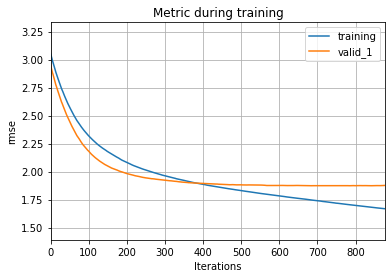

In [0]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(booster = model, metric='rmse')
plt.show()

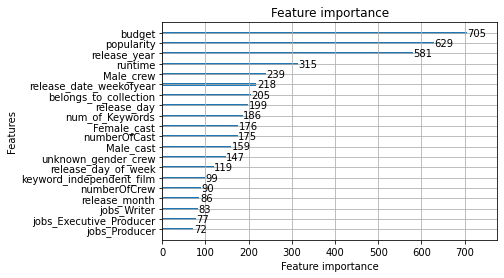

In [0]:
lgbm.plot_importance(model,max_num_features=20)

In [0]:
import time
start = time.time()
y_pred = model.predict(test_features)
stop = time.time()
print('Time: ', stop - start)

Time:  0.3909435272216797


In [0]:


from sklearn.metrics import mean_squared_error

def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))
def print_rf_score(model):
    print(f'Train R2:   {model.score(X_train, y_train)}')
    print(f'Valid R2:   {model.score(X_valid, y_valid)}')
    print(f'Train RMSE: {rmse(model.predict(X_train), y_train)}')
    print(f'Valid RMSE: {rmse(model.predict(X_valid), y_valid)}')
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50,n_jobs = -1, random_state = 42)
rf.fit(X_train, y_train)
print_rf_score(rf)


Train R2:   0.9266317379053344
Valid R2:   0.5065881033889974
Train RMSE: 0.8245742201694335
Valid RMSE: 2.238200385601874


In [0]:
test_predict = pd.DataFrame()
test_predict['id'] = test_ids
test_predict['revenue'] = np.expm1(y_pred)
test_predict.to_csv('keras2.csv', index=False)

In [0]:
from sklearn.tree import export_graphviz
# Export as dot file
estimator = rf.estimators_[1]

export_graphviz(estimator, 
                out_file='tree.dot')
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

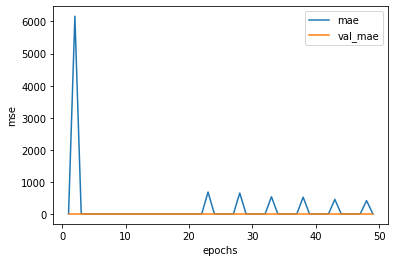

In [0]:
import tensorflow as tf

    
model=tf.keras.Sequential()
model.add(tf.keras.layers.Dense(356,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01),input_shape=(X_train.shape[1],)))
#model.add(layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(tf.keras.layers.Dense(1,activation='relu'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=opt,loss='mse'
,metrics=[tf.keras.metrics.RootMeanSquaredError()])
hist=model.fit(X_train,y_train,epochs=50,verbose=0,validation_data=(X_valid,y_valid))
epochs = 50
mae=hist.history['root_mean_squared_error']
plt.plot(range(1,epochs),mae[1:],label='mae')
plt.xlabel('epochs')
plt.ylabel('mse')
mae=hist.history['val_root_mean_squared_error']
plt.plot(range(1,epochs),mae[1:],label='val_mae')
plt.legend()

